# A3 Classification


## Definition of `NeuralNetworkClassifier`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import sys

import torch
import mlutilities as ml  
import optimizers as opt 

import neuralnetworks as nn



class NeuralNetworkClassifier(nn.NeuralNetwork):

    # Constructor
    def __init__(self, n_inputs, n_hiddens_list, classes, use_torch=False):


        
        if not isinstance(n_hiddens_list, list):
            raise Exception('NeuralNetworkClassifier: n_hiddens_list must be a list.')
 

        
        super().__init__(n_inputs, n_hiddens_list, len(classes), use_torch)


        
        self.classes = np.array(classes) 
        
        if use_torch:
            self.log = torch.log
            self.exp = torch.exp
        else:
            self.log = np.log
            self.exp = np.exp
        

# Rest of the Class Methods

    def __repr__(self):
        str = f'{type(self).__name__}({self.n_inputs}, {self.n_hiddens_list}, {self.classes}, use_torch={self.use_torch})'
        if self.trained:
            str += f'\n   Network was trained for {self.n_epochs} epochs'
            str += f' that took {self.training_time:.4f} seconds. Final objective value is {self.error_trace[-1]:.3f}'
        else:
            str += '  Network is not trained.'
        return str

    def _standardizeT(self, T):
        return T

    def _unstandardizeT(self, Ts):
        return Ts

    def _forward_pass(self, X):
       
        Z_prev = X  
        Z = [Z_prev]
        for i in range(self.n_hidden_layers):
            V = self.Vs[i]
            Z_prev = self.tanh(Z_prev @ V[1:, :] + V[0:1, :])
            Z.append(Z_prev)
        Y = np.exp(Z_prev @ self.W[1:, :] + self.W[0:1, :])
        Y = Y/np.sum(Y,axis = 1).reshape(-1, 1)
        return Y, Z

    def _objective_to_actual(self, neg_mean_log_likelihood):
        return self.exp(- neg_mean_log_likelihood)

    def _objectiveF(self, w, X, T):
        self._unpack(w)
        Y, _ = self._forward_pass(X)
        return -np.mean(T * (np.log(Y)))

    def train(self, X, T, n_epochs, method='scg',
        verbose=False, save_weights_history=False,
        learning_rate=0.001, momentum_rate=0.0): 

        if X.shape[1] != self.n_inputs:
            raise Exception(f'train: number of columns in X ({X.shape[1]}) not equal to number of network inputs ({self.n_inputs})')
        
        if self.use_torch:
            X = torch.tensor(X, dtype=torch.float)  
            T = torch.tensor(T, dtype=torch.float)

        self._setup_standardize(X, T)
        X = self._standardizeX(X)
        T = self._standardizeT(T)
        T_ind = makeIndicatorVars(T)
        
        try:
            algo = [opt.sgd, opt.adam, opt.scg][['sgd', 'adam', 'scg'].index(method)]
        except:
            raise Exception("train: method={method} not one of 'scg', 'sgd' or 'adam'")            

        result = algo(self._pack(self.Vs, self.W),
                      self._objectiveF,
                      [X, T_ind], n_epochs,
                      self._gradientF,  
                      eval_f=self._objective_to_actual,
                      learning_rate=learning_rate, momentum_rate=momentum_rate,
                      verbose=verbose, use_torch=self.use_torch,
                      save_wtrace=save_weights_history)

        self._unpack(result['w'])
        self.reason = result['reason']
        self.error_trace = result['ftrace'] 
        self.n_epochs = len(self.error_trace) - 1
        self.trained = True
        self.weight_history = result['wtrace'] if save_weights_history else None
        self.training_time = result['time']
        return self

    def use(self, X, all_outputs=False):
        if self.use_torch:
            if not isinstance(X, torch.Tensor):
                X = torch.tensor(X, dtype=torch.float)
        X = self._standardizeX(X)
        Y, Z = self._forward_pass(X)
        Y = self._unstandardizeT(Y)
        if self.use_torch:
            Y = Y.detach().cpu().numpy()
            Z = [Zi.detach().cpu().numpy() for Zi in Z]
        

        Y_classes = np.argmax(Y, axis= 1)

        return  (Y_classes.reshape(len(Y_classes),1), Y, Z[1:]) if all_outputs else (Y_classes.reshape(len(Y_classes),1), Y)


In [2]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
%matplotlib inline

import neuralnetworks as nn

In [3]:
#def makeIndicatorVars(T):
 #   if nnet_new.use_torch:
  #      if not isinstance(T, torch.Tensor):
   #         T= torch.Tensor(T, dtype=torch.int)
    #    if T.dim() == 1:
     #       T = T.reshape((-1,1))    
      #      return (T == torch.unique(T)).astype(int)
   # else:
    #    if T.ndim == 1:
     #       T= T.reshape((-1,1))
      #      return (T == np.unique(T)).astype(int)

In [4]:
def makeIndicatorVars(T):
    # Make sure T is two-dimensiona. Should be nSamples x 1.
    if T.ndim == 1:
        T = T.reshape((-1,1))    
    return (T == np.unique(T)).astype(int)

## Getting Data
Crowdsourced Mapping Data Set: This dataset was derived from geospatial data

In [5]:
!unzip -o Crowdsourced_Mapping.zip

Archive:  Crowdsourced_Mapping.zip
  inflating: training.csv            
  inflating: testing.csv             


In [6]:
data = pandas.read_csv('training.csv', usecols=range(20))
data= data[:1000]
data

,class,max_ndvi,20150720_N,20150602_N,20150517_N,20150501_N,20150415_N,20150330_N,20150314_N,20150226_N,20150210_N,20150125_N,20150109_N,20141117_N,20141101_N,20141016_N,20140930_N,20140813_N,20140626_N,20140610_N
0,water,997.904,637.5950,658.668,-1882.030,-1924.36000,997.904,-1739.99000,630.087,-1628.240,-1325.640,-944.0840,277.1070,-206.7990,536.441,749.348,-482.993,492.001,655.770,-921.193
1,water,914.198,634.2400,593.705,-1625.790,-1672.32000,914.198,-692.38600,707.626,-1670.590,-1408.640,-989.2850,214.2000,-75.5979,893.439,401.281,-389.933,394.053,666.603,-954.719
2,water,3800.810,1671.3400,1206.880,449.735,1071.21000,546.371,1077.84000,214.564,849.599,1283.630,1304.9100,542.1000,922.6190,889.774,836.292,1824.160,1670.270,2307.220,1562.210
3,water,952.178,58.0174,-1599.160,210.714,-1052.63000,578.807,-1564.63000,-858.390,729.790,-3162.140,-1521.6800,433.3960,228.1530,555.359,530.936,952.178,-1074.760,545.761,-1025.880
4,water,1232.120,72.5180,-1220.880,380.436,-1256.93000,515.805,-1413.18000,-802.942,683.254,-2829.400,-1267.5400,461.0250,317.5210,404.898,563.716,1232.120,-117.779,682.559,-1813.950
5,forest,7091.960,5102.9000,6996.710,201.956,6130.95000,6439.300,6818.67000,523.379,593.067,6357.930,6504.8400,397.8300,1566.2400,915.435,1602.510,1807.540,890.354,3998.800,7091.960
6,water,6423.920,1585.3100,2891.640,756.563,2978.58000,3215.560,5033.86000,5049.720,5520.140,5285.590,6156.1900,411.5510,6423.9200,5215.430,5737.360,5438.110,470.715,1583.780,521.130
7,water,2455.480,1136.4400,-761.046,205.408,1647.83000,1935.800,-44.56840,2158.980,-1367.920,1242.870,-2646.0500,-1238.0200,1564.3900,877.144,890.149,410.200,1160.250,2455.480,1535.000
8,water,2631.760,1116.8600,2631.760,-408.147,1685.70000,1046.670,-7.58804,1435.990,-1145.830,1269.330,-2070.4500,-819.1650,1737.6200,1064.970,840.433,248.060,1207.770,2408.210,1287.740
9,water,3192.460,1485.7700,-223.142,727.773,180.49100,1779.890,2613.97000,1869.390,-333.333,1821.830,-891.7200,178.7460,1389.5500,2136.840,824.788,316.108,1180.430,2722.310,3192.460


In [7]:
data2 = data[['max_ndvi', '20150720_N', '20150602_N', '20150517_N', '20150501_N', '20150415_N', '20150330_N', '20150314_N']]
data2
x1 = np.array([float(t) for t in data2['max_ndvi']])
x2 = np.array([float(t) for t in data2['20150720_N']])
x3 = np.array([float(t) for t in data2['20150602_N']])
x4 = np.array([float(t) for t in data2['20150517_N']])
x5 = np.array([float(t) for t in data2['20150501_N']])
x6 = np.array([float(t) for t in data2['20150415_N']])
x7 = np.array([float(t) for t in data2['20150330_N']])
x8 = np.array([float(t) for t in data2['20150314_N']])
X1 = (x1 ,x2, x3 , x4, x5, x6, x7, x8)
X1 = np.array(X1)
X=X1.T.reshape((-1,1))
X=X.reshape(1000,8)

In [8]:
Class = np.array(data['class'])
T=[0]*len(Class)


In [9]:
for i in range(len(Class)):
    if Class[i]== 'water':
        T[i]= 0
    elif Class[i] == 'forest':
        T[i]= 1
    elif Class[i] == 'impervious':
        T[i]= 2
    elif Class[i] == 'farm':
        T[i]= 3
    elif Class[i] == 'grass':
        T[i]= 4
    elif Class[i] == 'orchad':
        T[i]= 5
T = np.array(T).reshape((-1,1))


In [10]:
X.shape,T.shape

((1000, 8), (1000, 1))

In [11]:
T=T.astype(float)

## Testing The Data

In [12]:
nnet_new = NeuralNetworkClassifier(8, [25, 25], [0, 1])
nnet_new

NeuralNetworkClassifier(8, [25, 25], [0 1], use_torch=False)  Network is not trained.

In [13]:
nnet_new.train(X, T, 100)

NeuralNetworkClassifier(8, [25, 25], [0 1], use_torch=False)
   Network was trained for 100 epochs that took 0.1290 seconds. Final objective value is 0.992

In [14]:
Y_classes, Y = nnet_new.use(X)
Y_classes.shape, Y.shape

((1000, 1), (1000, 2))

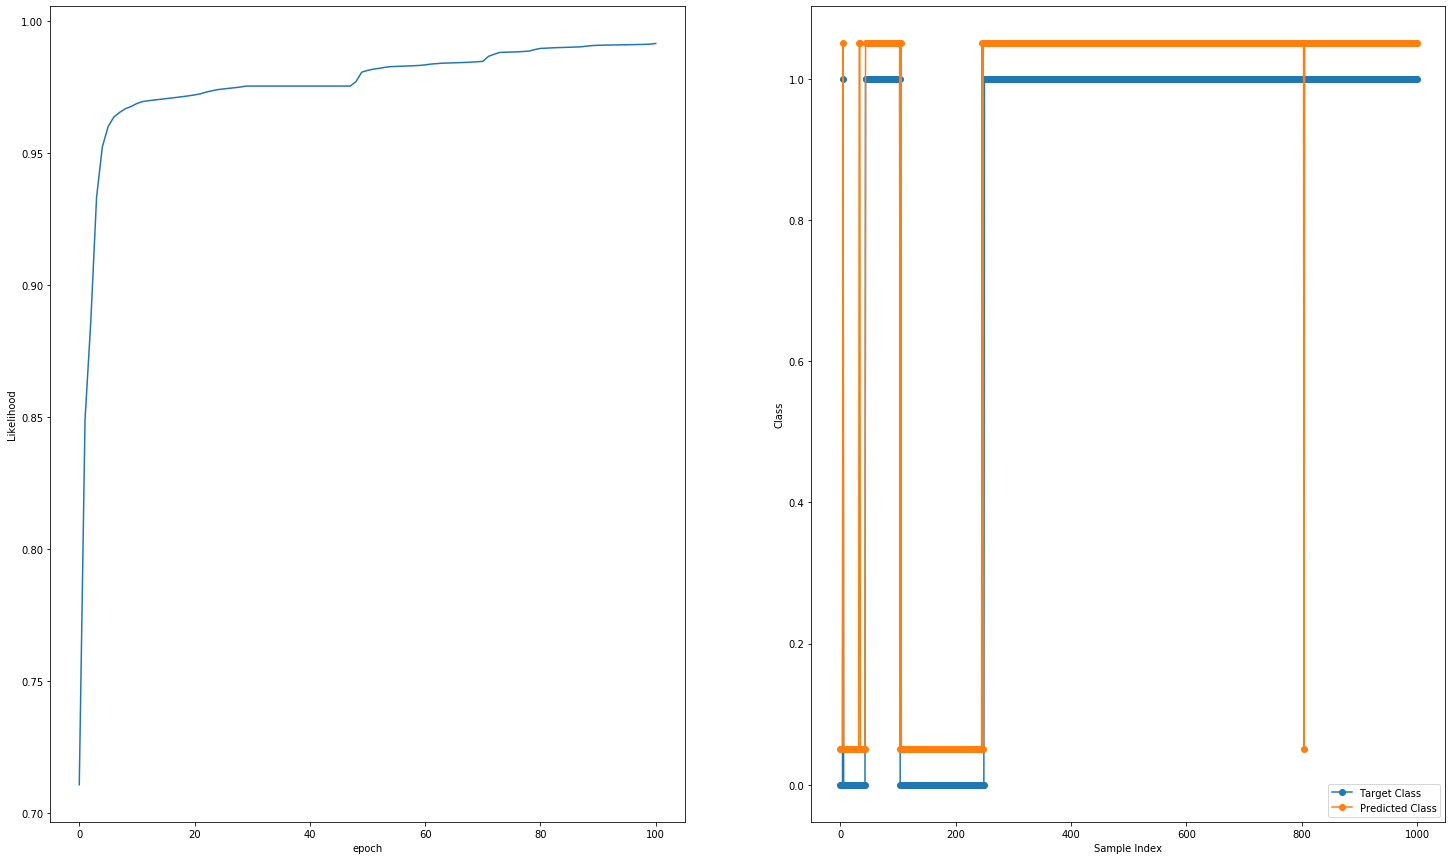

In [15]:
plt.figure(figsize=(25, 15))
plt.subplot(1, 2, 1)
plt.plot(nnet_new.get_error_trace())
plt.xlabel('epoch')
plt.ylabel('Likelihood')

plt.subplot(1, 2, 2)
plt.plot(T, 'o-')
plt.plot(Y_classes + 0.05, 'o-')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend(['Target Class', 'Predicted Class']);

### With Different epochs, different network size and optimization algorithms

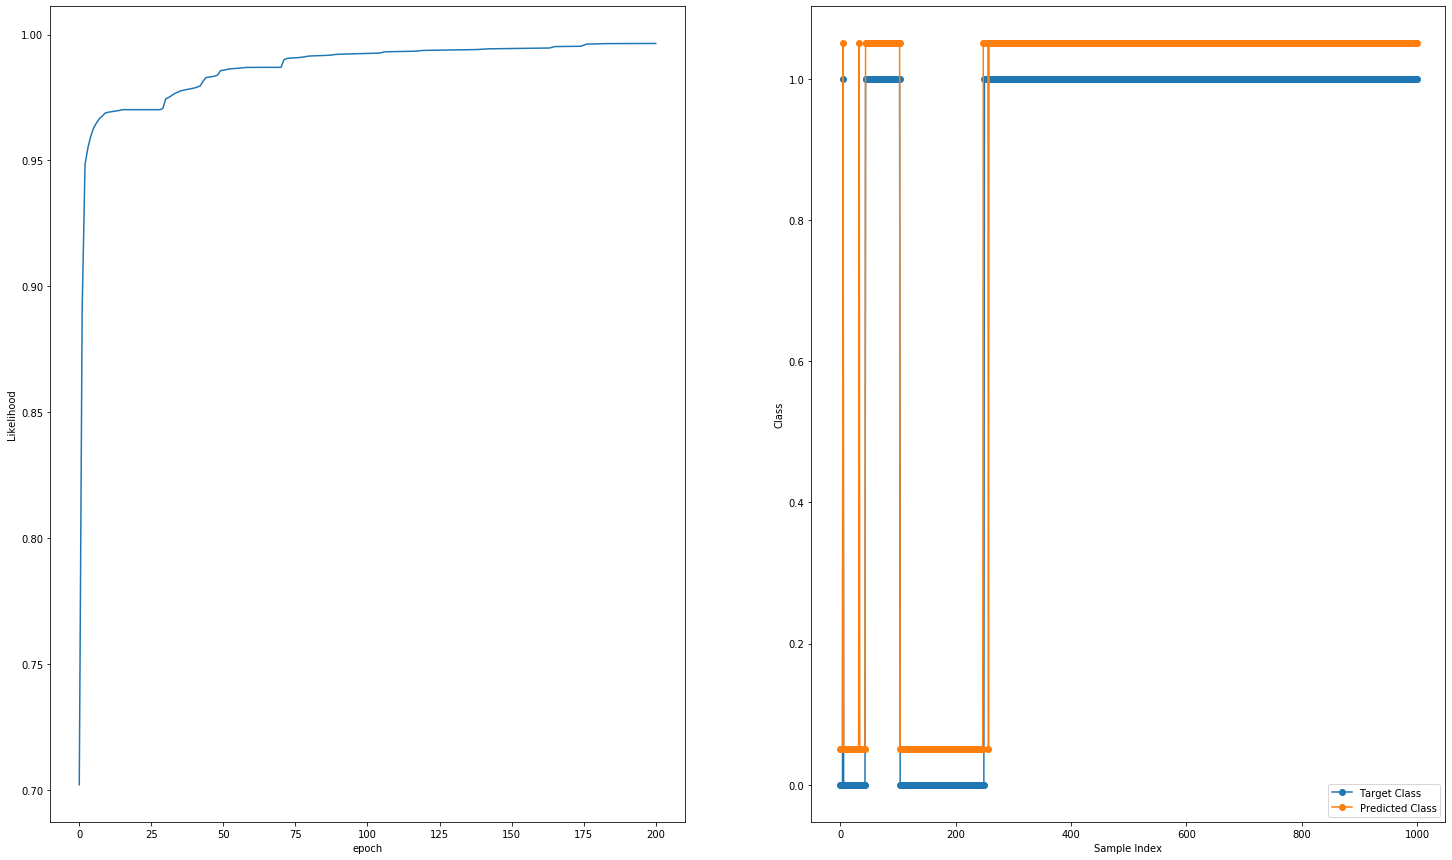

In [16]:
nnet_new = NeuralNetworkClassifier(8, [20, 25], [0, 1])
nnet_new.train(X, T, 200) #200 epochs
Y_classes, Y = nnet_new.use(X)
Y_classes.shape, Y.shape
plt.figure(figsize=(25, 15))
plt.subplot(1, 2, 1)
plt.plot(nnet_new.get_error_trace())
plt.xlabel('epoch')
plt.ylabel('Likelihood')

plt.subplot(1, 2, 2)
plt.plot(T, 'o-')
plt.plot(Y_classes + 0.05, 'o-')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend(['Target Class', 'Predicted Class']);

### SGD 

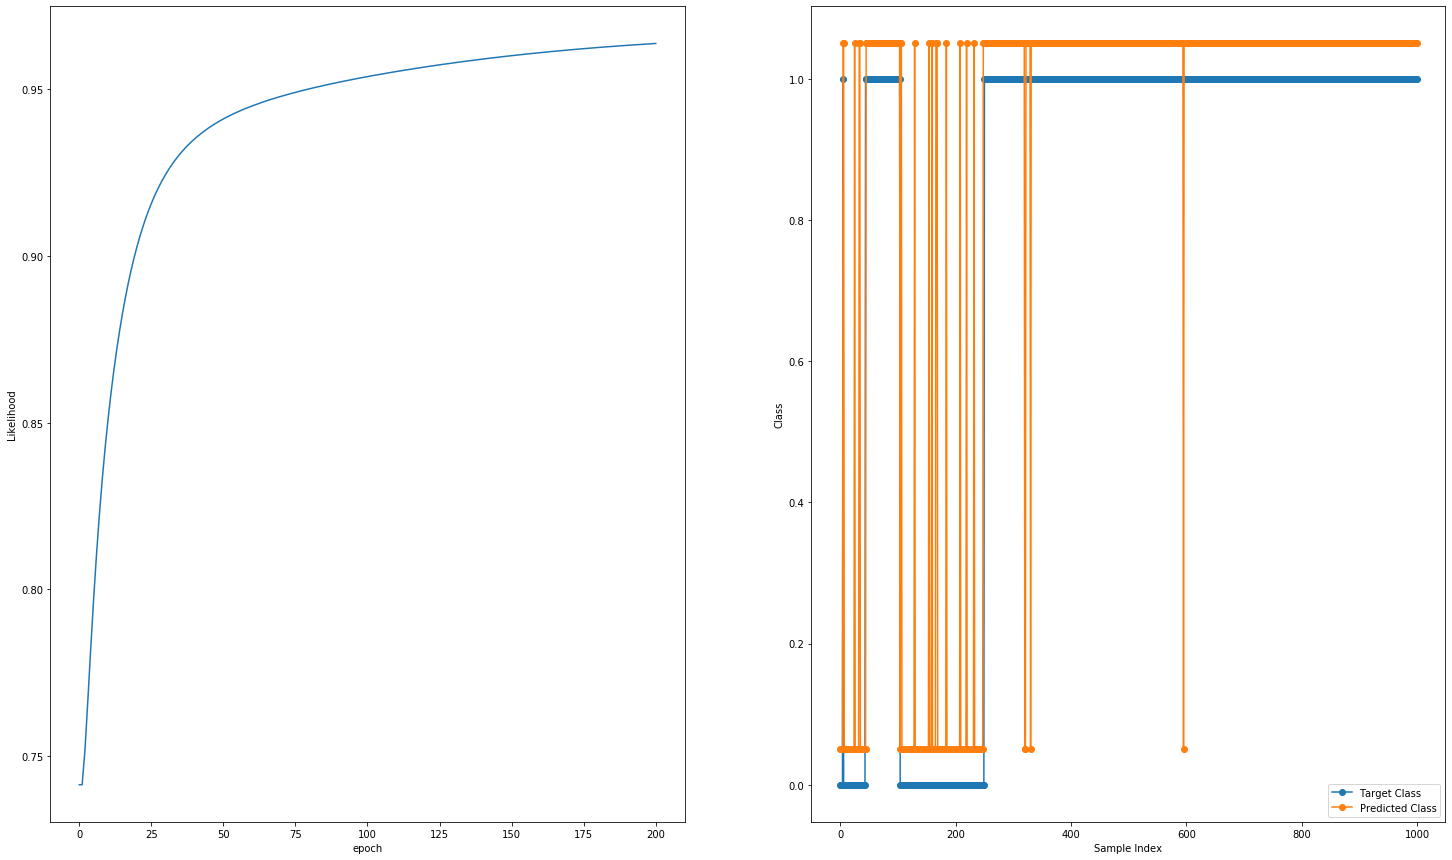

In [17]:
nnet_new = NeuralNetworkClassifier(8, [25, 25], [0, 1])
nnet_new.train(X, T, 200, method='sgd', learning_rate=0.1, momentum_rate=0.5)
Y_classes, Y = nnet_new.use(X)
Y_classes.shape, Y.shape
plt.figure(figsize=(25, 15))
plt.subplot(1, 2, 1)
plt.plot(nnet_new.get_error_trace())
plt.xlabel('epoch')
plt.ylabel('Likelihood')

plt.subplot(1, 2, 2)
plt.plot(T, 'o-')
plt.plot(Y_classes + 0.05, 'o-')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend(['Target Class', 'Predicted Class']);

### SCG

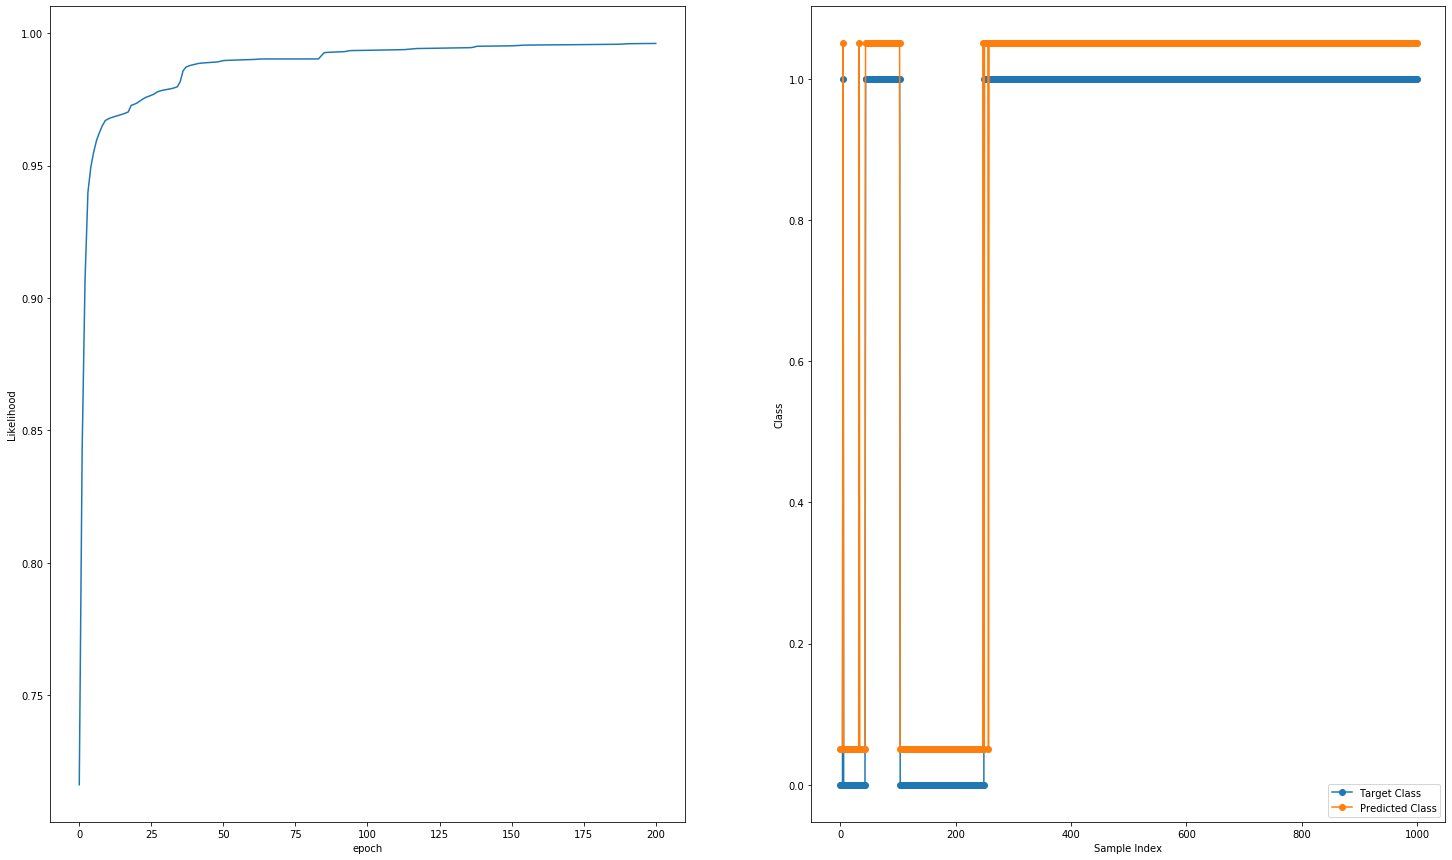

In [18]:
nnet_new = NeuralNetworkClassifier(8, [25, 25], [0, 1])
nnet_new.train(X, T, 200, method='scg')
Y_classes, Y = nnet_new.use(X)
Y_classes.shape, Y.shape
plt.figure(figsize=(25, 15))
plt.subplot(1, 2, 1)
plt.plot(nnet_new.get_error_trace())
plt.xlabel('epoch')
plt.ylabel('Likelihood')

plt.subplot(1, 2, 2)
plt.plot(T, 'o-')
plt.plot(Y_classes + 0.05, 'o-')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend(['Target Class', 'Predicted Class']);

### ADAM

In [22]:
nnet_new = NeuralNetworkClassifier(8, [25, 25], [0, 1])
nnet_new.train(X, T, 200, method='adam', learning_rate=0.1)
Y_classes, Y = nnet_new.use(X)
Y_classes.shape, Y.shape
plt.figure(figsize=(25, 15))
plt.subplot(1, 2, 1)
plt.plot(nnet_new.get_error_trace())
plt.xlabel('epoch')
plt.ylabel('Likelihood')

plt.subplot(1, 2, 2)
plt.plot(T, 'o-')
plt.plot(Y_classes + 0.05, 'o-')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend(['Target Class', 'Predicted Class']);

Exception: train: number of columns in X (1) not equal to number of network inputs (8)

### Discussion

While working with the data almost more than 2000 samples taken were either water or forest, hence, while working with it we must alter the classifications and number of samples simultaneously and carefully. 

0 in the graphs above means 'water' and 1 is 'forest'; and also I didn't consider all the months of data, rather 6 months of data in the year of 2015. 

Limited to the information, our algorithms still perform quite good. Saying that, we must note SGD does quite poorly compared to SCG and ADAM. 

In [23]:
%run -i A3grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Tamidapati-A3.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing if your NeuralNetworkClassifier can learn to detect vowels when given
their ascii codes.

import numpy as np
ascii_code = list(range(65, 91)) + list(range(97, 123))
chars = [chr(n).lower() for n in ascii_code]
vowel = [c in ['a', 'e', 'i', 'o', 'u'] for c in chars]
X = np.array(ascii_code).reshape((-1, 1))
T = np.array(vowel).reshape((-1, 1))
classes = np.unique(T)

np.random.seed(120)
nnet = NeuralNetworkClassifier(X.shape[1], [50, 20, 20], classes)
nnet.train(X, T, 10000, verbose=True)
Yc, Y = nnet.use(X)
n_correct = (Yc == T).sum()
print(f'{n_correct} out of {T.shape[0]} samples, or {n_correct/T.shape[0]*100:.2f} percent.')
SCG: Iteration 1000 ObjectiveF=0.79634 Scale=1.000e-15 Seconds=0.814
SCG: Iteration 2000 ObjectiveF=0.81790 Scale

notebookcodeStripped:77: RuntimeWarning: invalid value encountered in true_divide
notebookcodeStripped:86: RuntimeWarning: divide by zero encountered in log
notebookcodeStripped:86: RuntimeWarning: invalid value encountered in multiply


SCG: Iteration 9000 ObjectiveF=0.99626 Scale=1.000e-15 Seconds=0.859
SCG: Iteration 10000 ObjectiveF=0.99866 Scale=1.000e-15 Seconds=0.875
52 out of 52 samples, or 100.00 percent.

--- 80/80 points. Returned correct value of 52.

CS545 Execution Grade is 80 / 80

 __ / 10 You obtained data for a classification problem and set up
         X and T matrices correctly.

 __ / 10 You compared several different network sizes, numbers of
         epochs, and optimization algoritms and described the results.

CS545 FINAL GRADE is  _  / 100

Extra Credit:
1. For the data set you have downloaded, randomly partition the data into about
   80% for training and 20% for testing. Discuss the percent of samples correctly
   classified for train and test partitions and how variations in netowrk size, 
   epochs, and optimization algorithm effect the results.
2. Develop a new version of optimizers.py, neuralnetworks.py and your
   NeuralNetworkClassifier class that will run on a GPU using pytorch. 
   A